In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

%matplotlib inline

In [2]:
# loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset_list = [train, test] # to do feature engineering and data cleaning
dataset_com = pd.concat(dataset_list,axis=0,sort=True)

In [3]:
# Exploring empty cells and cell type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* PassengerId — unique id - **no nulls**
* Survived — Survival - 0= No, 1 = yes - **not available for test data**
* Pclass — Ticket class	- 1 = 1st, 2 = 2nd, 3 = 3rd - **no nulls**
* Name — name of the passenger - **no nulls**
* Sex — Sex - **no nulls**
* Age — Age in years - **have nulls**
* SibSp — # of siblings / spouses aboard the Titanic - **no nulls**
* Parch — # of parents / children aboard the Titanic - **no nulls**
* Ticket — Ticket number - **no nulls**
* Fare — Passenger fare - **1 null in test data**
* Cabin - Cabin number - **null where no cabin - can replace null value with no_cabin**
* Embarked - Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton - **2 nulls in train data**

# Data Exploration and Feature Engineering

In [5]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [6]:
test.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


# Feature engineering

## Features inspired by https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
* Family Size as combination of SibSb + Parch - from Sina
* DoTicketNumberHasMultiple - may indicate traveling with friends/family
* GroupHasKid using ticket number( indicator of same group)
* IsAlone from FamilySize and DoTicketNumberHasMultiple - inspired from Sina
* Bins
    * Fare more like pclass++, if we use this can drop pclass as it become redundant.
    * Age Group - from Sina
    * Title based on extracted value - from Sina
* HasCabin
* CabinType based on Fare and HasCabin (0 - no cabin, 1 - shared cabin, 2 - private cabin) - this gives same information as pclass++, we can drop it, also if needed check via P-value.
* TravelTime in Days before hitting iceberg (15th April 1912) calculated based on embarkment port route of  S(11), C(5), Q(4) using info from https://discovernorthernireland.com/things-to-do/attractions/titanic/titanic-sailing-route-map/

In [7]:
# 1. FamilySize
for dataset in dataset_list:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


 seems to have good impact

In [8]:
# 2. IsAlone
# check if columns have duplicate ticket number. Duplicate ticket numbers symbolize family/friends
tks = dataset_com['Ticket']
dataset_dup = dataset_com[tks.isin(tks[tks.duplicated()])]

In [9]:
for dataset in dataset_list:
    dataset['TkDup'] = dataset.Ticket.isin(dataset_dup['Ticket'])

In [10]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,False


Now using family size and Tkdup as indicator of travel group we calculate whether person is alone in this ship or not

In [11]:
for dataset in dataset_list:
    dataset['IsAlone'] = 0
    dataset_filter = (dataset['FamilySize'] == 1) & (dataset['TkDup'] == False)
    dataset['IsAlone'] = np.where(dataset_filter, 1, 0)

In [12]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,False,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2,False,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,False,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,False,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,3,True,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,1,False,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,False,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,3,True,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,False,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,3,True,0


In [13]:
train[train['Ticket'] == '1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1,True,0
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1,True,0
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,True,0
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,True,0


Above shows case where though family size is 1 but ticket number is duplicate, these guys must belong to same group

In [14]:
# 3. pclass++ (update class if have cabin)
dataset_com.groupby('Pclass').count()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket
Pclass,,,,,,,,,,,
1,284,256,321,323,323,323,323,323,323,216,323
2,261,23,277,277,277,277,277,277,277,184,277
3,501,16,709,708,709,709,709,709,709,491,709


In [15]:
for dataset in dataset_list:
    dataset['pclass++'] = dataset['Pclass']
    dataset_filter = pd.notna(dataset['Cabin'])
    dataset['pclass++'] = np.where(dataset_filter, 0, dataset['pclass++'].values)

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,True,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,False,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,True,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,False,1,3


In [17]:
# 3. Embarked
# cleaning values
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,True,0,0


Since they have duplicate ticket number, we can use value from same ticket number

In [18]:
train[train.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,True,0,0


but since no other member same ticket number and both missing, we will assign value of most occured in same Pclass i.e. 1 here

In [19]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
dataset_com.groupby(['Embarked', 'pclass++']).size()

Embarked  pclass++
C         0           118
          1            30
          2            24
          3            98
Q         0             5
          2             6
          3           112
S         0           170
          1            37
          2           224
          3           483
dtype: int64

In [20]:
# Since majority of height class people embarked in S, assigning the same values
train['Embarked'] = train['Embarked'].fillna('S')

In [21]:
train[train.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,1,True,0,0


In [22]:
# 4 . Fare as we know only 1 value is missing in test data
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,False,1,3


In [23]:
# lets replace that with median value in that category
test.groupby('pclass++').median()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,TkDup,IsAlone
pclass++,,,,,,,,,
0,1094.0,1.0,39.0,1.0,0.0,61.9792,2.0,True,0
1,1109.0,1.0,43.5,0.0,0.0,31.6833,1.0,False,1
2,1121.5,2.0,27.5,0.0,0.0,18.5000,1.0,True,0
3,1091.5,3.0,24.0,0.0,0.0,7.8958,1.0,False,1


In [24]:
test.loc[test.Fare.isnull(), 'Fare'] = test.groupby('pclass++').Fare.transform('median')
test[test.PassengerId == 1044]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.8958,NaN,S,1,False,1,3


In [25]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
#updating list with new data

In [26]:
# Title derived from Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # regex starting with space ending with .
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in dataset_list:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [27]:
# 5. Title Group all non-common titles into group based on gender
for dataset in dataset_list:
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms', 'Countess', 'Lady', 'Dona'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Capt','Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr')

print(pd.crosstab(train['Title'], train['Sex']))

Sex     female  male
Title               
Dr           1     6
Master       0    40
Miss       187     0
Mr           0   531
Mrs        126     0


In [28]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
#updating combine list with new data

In [29]:
print (dataset_com[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0      Dr  0.428571
1  Master  0.575000
2    Miss  0.705882
3      Mr  0.158192
4     Mrs  0.793651


In [30]:
# 6. Age - as we have seen multiple values are missing, lets assign them mean value for particular class and title
train.groupby(['Title', 'pclass++']).mean()

PassengerId  Survived    Pclass        Age     SibSp  \
Title  pclass++                                                         
Dr     0          558.666667  0.666667  1.000000  41.666667  0.666667   
       1          714.000000  0.500000  1.000000  50.000000  1.000000   
       2          358.500000  0.000000  2.000000  38.500000  0.000000   
Master 0          432.285714  1.000000  1.714286   3.988571  0.857143   
       2          575.500000  1.000000  2.000000   2.388333  0.666667   
       3          374.814815  0.370370  3.000000   5.322609  3.037037   
Miss   0          419.862745  0.941176  1.215686  28.316327  0.450980   
       1          475.428571  1.000000  1.000000  30.833333  0.000000   
       2          441.233333  0.933333  2.000000  22.655172  0.233333   
       3          399.525253  0.494949  3.000000  16.514925  1.020202   
Mr     0          457.704082  0.377551  1.132653  41.267442  0.306122   
       1          401.800000  0.200000  1.000000  43.937500  0.080000   
       2          457.734043  0.074468  2.000000  33.405882  0.308511   
       3          460.168790  0.111465  3.000000  28.711111  0.289809   
Mrs    0          487.377778  0.933333  1.244444  38.475000  0.644444   
       1          453.833333  1.000000  1.000000  44.666667  0.833333   
       2          449.138889  0.916667  2.000000  33.388889  0.777778   
       3          415.153846  0.487179  3.000000  34.200000  0.641026   

                    Parch        Fare  FamilySize     TkDup   IsAlone  
Title  pclass++                                                        
Dr     0         0.000000   48.809733    1.666667  0.333333  0.666667  
       1         0.000000   86.625000    2.000000  0.500000  0.500000  
       2         0.000000   12.250000    1.000000  0.000000  1.000000  
Master 0         1.428571   65.269043    3.285714  1.000000  0.000000  
       2         1.333333   25.792367    3.000000  1.000000  0.000000  
       3         1.370370   28.758796    5.407407  1.000000  0.000000  
Miss   0         0.607843   95.808576    2.058824  0.784314  0.156863  
       1         0.000000  174.080357    1.000000  1.000000  0.000000  
       2         0.600000   20.617917    1.833333  0.466667  0.466667  
       3         0.515152   15.209895    2.535354  0.414141  0.525253  
Mr     0         0.295918   66.675597    1.602041  0.489796  0.500000  
       1         0.040000   44.433828    1.120000  0.320000  0.680000  
       2         0.117021   19.255141    1.425532  0.404255  0.574468  
       3         0.127389   11.356287    1.417197  0.200637  0.742038  
Mrs    0         0.422222   77.980187    2.066667  0.866667  0.133333  
       1         0.166667   95.214583    2.000000  1.000000  0.000000  
       2         0.750000   25.140278    2.527778  0.861111  0.138889  
       3         1.461538   18.619762    3.102564  0.846154  0.128205

In [31]:
# setting age to median value
for dataset in dataset_list:
    dataset.loc[dataset.Age.isnull(), 'Age'] = dataset.groupby(['Title', 'pclass++']).Age.transform('mean')

In [32]:
#6. Fill empty cabin with no cabin
for dataset in dataset_list:
    dataset.loc[dataset.Cabin.isnull(), 'Cabin'] = 'NoCabin'

In [33]:
#7. Time travelled S(11), C(5), Q(4)
for dataset in dataset_list:
    dataset['TimeTravelled'] = 11
    dataset_filter = (dataset['Embarked'] == 'C')
    dataset_filter_1 = (dataset['Embarked'] == 'Q')
    dataset['TimeTravelled'] = np.where(dataset_filter, 5, dataset['TimeTravelled'].values)
    dataset['TimeTravelled'] = np.where(dataset_filter_1, 4, dataset['TimeTravelled'].values)

In [34]:
# convert fields from float to int
for dataset in dataset_list:
    dataset['Age'] = dataset['Age'].astype('int64')
    dataset['Fare'] = dataset['Fare'].astype('int64')
    dataset['IsAlone'] = dataset['IsAlone'].astype('int64')

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null int64
SibSp            891 non-null int64
Parch            891 non-null int64
Ticket           891 non-null object
Fare             891 non-null int64
Cabin            891 non-null object
Embarked         891 non-null object
FamilySize       891 non-null int64
TkDup            891 non-null bool
IsAlone          891 non-null int64
pclass++         891 non-null int64
Title            891 non-null object
TimeTravelled    891 non-null int64
dtypes: bool(1), int64(11), object(6)
memory usage: 119.3+ KB


In [36]:
# Feature selection
# Store our passenger ID for easy access
PassengerId = test['PassengerId']
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Fare', 'TkDup', 'Pclass']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [37]:
train.head(3)

,Survived,Sex,Age,Parch,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,0,male,22,0,S,2,0,3,Mr,11
1,1,female,38,0,C,2,0,0,Mrs,5
2,1,female,26,0,S,1,1,3,Miss,11


In [38]:
test.head(3)

,Sex,Age,Parch,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,male,34,0,Q,1,1,3,Mr,4
1,female,47,0,S,2,0,3,Mrs,11
2,male,62,0,Q,1,1,2,Mr,4


In [39]:
# picking out the relevant attributes for regression modelling
correlation = train.corr(method='pearson')
columns = correlation.nlargest(7, 'Survived').index
columns

Index(['Survived', 'Parch', 'FamilySize', 'Age', 'TimeTravelled', 'IsAlone',
       'pclass++'],
      dtype='object')

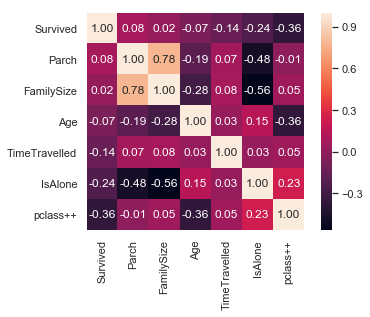

In [40]:
correlation_map = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

This shows family size and parch are coorelated

# Pairplots
Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


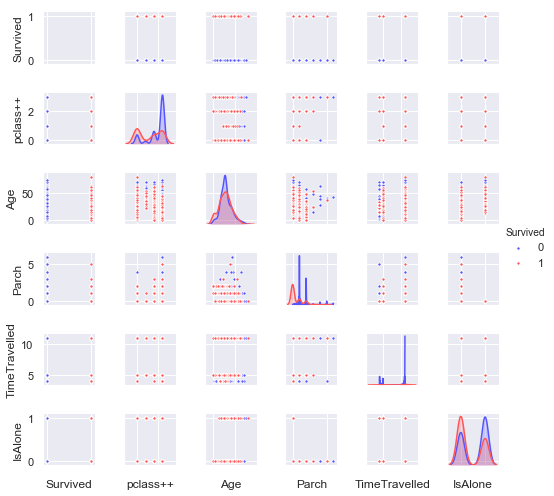

In [41]:
g = sns.pairplot(train[[u'Survived', u'pclass++', u'Age', u'Parch', u'TimeTravelled',
       u'IsAlone']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [42]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
dataset_com = dataset_com.drop(drop_elements, axis=1)
#updating combine list with new data

In [43]:
dataset_com.head(1)
# X = dataset_com.iloc[:, :-1].values # features or independent variables

,Age,Embarked,FamilySize,IsAlone,Parch,Sex,Survived,TimeTravelled,Title,pclass++
0,22,S,2,0,0,male,0.0,11,Mr,3


In [44]:
train.head(1)

,Survived,Sex,Age,Parch,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,0,male,22,0,S,2,0,3,Mr,11


In [45]:
# preparing data for training and prediction
X = dataset_com.iloc[:,[5,0,4,1,2,3,9,8,7]].values
X_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values
X_test = test.values
# labels are sex 0, age 1, parch 2, embarked 3, family size 4, isAlone 5, pclass++ 6, title 7, timetravelled 8

In [46]:
X[1,:]

array(['female', 38, 0, 'C', 2, 0, 0, 'Mrs', 5], dtype=object)

In [47]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
# encoding sex
labelEncoder_sex = LabelEncoder()
labelEncoder_sex = labelEncoder_sex.fit(X[:,0]) # fitting on full set

In [48]:
X[:,0] = labelEncoder_sex.transform(X[:,0])

In [49]:
X_train[:,0] = labelEncoder_sex.transform(X_train[:,0])

In [50]:
X_test[:,0] = labelEncoder_sex.transform(X_test[:,0])

In [51]:
X_train[1,:]

array([0, 38, 0, 'C', 2, 0, 0, 'Mrs', 5], dtype=object)

In [52]:
X_test[1,:]

array([0, 47, 0, 'S', 2, 0, 3, 'Mrs', 11], dtype=object)

In [53]:
# encoding embarkment
labelEncoder_em = LabelEncoder()
labelEncoder_em = labelEncoder_em.fit(X[:,3]) # fitting on full set

In [54]:
X[:,3] = labelEncoder_em.transform(X[:,3])

In [55]:
X_train[:,3] = labelEncoder_em.transform(X_train[:,3])

In [56]:
X_test[:,3] = labelEncoder_em.transform(X_test[:,3])

In [57]:
# encoding Title
labelEncoder_ttl = LabelEncoder()
labelEncoder_ttl = labelEncoder_ttl.fit(X[:,7]) # fitting on full set

In [58]:
X[:,7] = labelEncoder_ttl.transform(X[:,7])

In [59]:
X_train[:,7] = labelEncoder_ttl.transform(X_train[:,7])
X_test[:,7] = labelEncoder_ttl.transform(X_test[:,7])

In [60]:
X[:3,:]

array([[1, 22, 0, 2, 2, 0, 3, 3, 11],
       [0, 38, 0, 0, 2, 0, 0, 4, 5],
       [0, 26, 0, 2, 1, 1, 3, 2, 11]], dtype=object)

In [61]:
# onehot encoding embarkment
from sklearn.preprocessing import OneHotEncoder
onehotencoder_em = OneHotEncoder(categorical_features = [3])
onehotencoder_em = onehotencoder_em.fit(X)

In [62]:
X = onehotencoder_em.transform(X).toarray()

In [63]:
X[:3,:]

array([[  0.,   0.,   1.,   1.,  22.,   0.,   2.,   0.,   3.,   3.,  11.],
       [  1.,   0.,   0.,   0.,  38.,   0.,   2.,   0.,   0.,   4.,   5.],
       [  0.,   0.,   1.,   0.,  26.,   0.,   1.,   1.,   3.,   2.,  11.]])

In [64]:
X_train[:3,:]

array([[1, 22, 0, 2, 2, 0, 3, 3, 11],
       [0, 38, 0, 0, 2, 0, 0, 4, 5],
       [0, 26, 0, 2, 1, 1, 3, 2, 11]], dtype=object)

In [65]:
X_train = onehotencoder_em.transform(X_train).toarray()

In [66]:
X_train[:3,:]

array([[  0.,   0.,   1.,   1.,  22.,   0.,   2.,   0.,   3.,   3.,  11.],
       [  1.,   0.,   0.,   0.,  38.,   0.,   2.,   0.,   0.,   4.,   5.],
       [  0.,   0.,   1.,   0.,  26.,   0.,   1.,   1.,   3.,   2.,  11.]])

In [67]:
X_test[:3,:]

array([[1, 34, 0, 1, 1, 1, 3, 3, 4],
       [0, 47, 0, 2, 2, 0, 3, 4, 11],
       [1, 62, 0, 1, 1, 1, 2, 3, 4]], dtype=object)

In [68]:
X_test = onehotencoder_em.transform(X_test).toarray()

In [69]:
X_test[:3,:]

array([[  0.,   1.,   0.,   1.,  34.,   0.,   1.,   1.,   3.,   3.,   4.],
       [  0.,   0.,   1.,   0.,  47.,   0.,   2.,   0.,   3.,   4.,  11.],
       [  0.,   1.,   0.,   1.,  62.,   0.,   1.,   1.,   2.,   3.,   4.]])

In [70]:
# avoding dummy variable trap for embarkment by dropping one value
X = X[:,1:]
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [76]:
print(X.shape, X_train.shape, X_test.shape)

(1309, 10) (891, 10) (418, 10)


new labels are now, em_1 (0), em_2(1), sex(2), age(3), parch(4), famil_size(5), IsAlone(6),pclass++(7),title(8),timetravelled(9)

In [77]:
# onehot encoding title
from sklearn.preprocessing import OneHotEncoder
onehotencoder_ttl = OneHotEncoder(categorical_features = [8])
onehotencoder_ttl = onehotencoder_ttl.fit(X) # again fitting on full set

In [78]:
X = onehotencoder_ttl.transform(X).toarray()
X[:3,:] # five type of titles converted to five columns in start

array([[  0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,  22.,   0.,   2.,
          0.,   3.,  11.],
       [  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,  38.,   0.,   2.,
          0.,   0.,   5.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,  26.,   0.,   1.,
          1.,   3.,  11.]])

In [79]:
X_train = onehotencoder_ttl.transform(X_train).toarray()

In [80]:
X_test = onehotencoder_ttl.transform(X_test).toarray()

In [81]:
# avoding dummy variable trap for title by dropping one value
X = X[:,1:]
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [83]:
X[:5,:]

array([[  0.,   0.,   1.,   0.,   0.,   1.,   1.,  22.,   0.,   2.,   0.,
          3.,  11.],
       [  0.,   0.,   0.,   1.,   0.,   0.,   0.,  38.,   0.,   2.,   0.,
          0.,   5.],
       [  0.,   1.,   0.,   0.,   0.,   1.,   0.,  26.,   0.,   1.,   1.,
          3.,  11.],
       [  0.,   0.,   0.,   1.,   0.,   1.,   0.,  35.,   0.,   2.,   0.,
          0.,  11.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   1.,  35.,   0.,   1.,   1.,
          3.,  11.]])

new labels are now, ttl_1(0), ttl_2(1), ttl_3(2), ttl4(3), em_1 (4), em_2(5), sex(6), age(7), parch(8), famil_size(9), IsAlone(10),pclass++(11),timetravelled(12)

In [84]:
print(X.shape, X_train.shape, X_test.shape)

(1309, 13) (891, 13) (418, 13)


# Baseline algorithm test

In [141]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# testing various classification models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledLOR', Pipeline([('Scaler', StandardScaler()),('LOR', LogisticRegression())])))
pipelines.append(('ScaledXGBR', Pipeline([('Scaler', StandardScaler()),('XGBR', XGBRegressor())])))
pipelines.append(('ScaledXGBC', Pipeline([('Scaler', StandardScaler()),('XGBC', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])))
pipelines.append(('ScaledKNC', Pipeline([('Scaler', StandardScaler()),('KNC', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC(kernel = 'rbf'))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', StandardScaler()),('SVC', GaussianNB())])))
pipelines.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier(criterion = 'entropy'))])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier(n_estimators = 10, criterion = 'entropy'))])))
pipelines.append(('ScaledABC', Pipeline([('Scaler', StandardScaler()),('ABC', AdaBoostClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train_1, Y_train_1, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLOR: -0.170587 (0.030841)
ScaledXGBC: -0.166105 (0.033998)
ScaledKNC: -0.189650 (0.027535)
ScaledSVC: -0.166117 (0.039225)
ScaledGNB: -0.199750 (0.039989)
ScaledDTC: -0.204170 (0.042514)
ScaledRFC: -0.206467 (0.036701)
ScaledABC: -0.185169 (0.037926)


In [146]:
# testing various classification models using f1 score
pipelines_1 = []
pipelines_1.append(('ScaledLOR', Pipeline([('Scaler', StandardScaler()),('LOR', LogisticRegression())])))
pipelines_1.append(('ScaledXGBC', Pipeline([('Scaler', StandardScaler()),('XGBC', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])))
pipelines_1.append(('ScaledKNC', Pipeline([('Scaler', StandardScaler()),('KNC', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))])))
pipelines_1.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC(kernel = 'rbf'))])))
pipelines_1.append(('ScaledGNB', Pipeline([('Scaler', StandardScaler()),('SVC', GaussianNB())])))
pipelines_1.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier(criterion = 'entropy'))])))
pipelines_1.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier(n_estimators = 10, criterion = 'entropy'))])))
pipelines_1.append(('ScaledABC', Pipeline([('Scaler', StandardScaler()),('ABC', AdaBoostClassifier())])))

results = []
names = []
for name, model in pipelines_1:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.02f%%" % (name, np.mean(cv_results)*100)
    print(msg)

ScaledLOR: 76.68%
ScaledXGBC: 76.47%
ScaledKNC: 73.64%
ScaledSVC: 76.46%
ScaledGNB: 73.52%
ScaledDTC: 71.84%
ScaledRFC: 72.49%
ScaledABC: 75.02%


From the output above, it looks like XGBClassider out performs the best using a scaled version of the data.I will select XGBC for further analysis

# Lets optimize XGBC further using grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train_1)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))